<img style="float: left;padding: 1.3em" src="https://raw.githubusercontent.com/gw-odw/odw-2022/main/Tutorials/logo.png">  

#  Gravitational Wave Open Data Workshop #5


#### Tutorial 1.3: Data representations in GWpy

This notebook covers some different ways of representing data, including

  - the spectrogram
  - the Q-transform

with a challenge you can explore for each method. 
    
[Click this link to view this tutorial in Google Colaboratory](https://colab.research.google.com/github/gw-odw/odw-2022/blob/main/Tutorials/Day_1/Tuto%201.3%20Q-transforms%20with%20GWpy.ipynb)

##  Installation  (execute only if running on a cloud platform, like Google Colab, or if you haven't done the installation already!)

Note: we use [`pip`](https://docs.python.org/3.6/installing/), but **it is recommended** to use [conda](https://docs.ligo.org/lscsoft/conda/) on your own machine, as explained in the [installation instructions](https://github.com/gw-odw/odw-2021/blob/master/setup.md). This usage might look a little different than normal, simply because we want to do this directly from the notebook.

In [15]:
# -- Uncomment following line if running in Google Colab
#! pip install -q 'gwpy==2.0.2'

**Important:** With Google Colab, you may need to restart the runtime after running the cell above.

## Initialization

In [16]:
%matplotlib inline
import gwpy

## Showing the time-evolution of FFTs

The FFT, and the ASD, show us a snapshot of the frequency-domain content of our signal, referred to a single time interval.
It is commonly useful to show how this frequency-domain content evolves over time.

For this we use spectrograms, which show the FFT (or ASD) at each time step on a time-frequency representation.
The `TimeSeries` in GWpy includes two methods for this:

- [`spectrogram()`](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html#gwpy.timeseries.TimeSeries.spectrogram) - which includses a `stride` parameter, and shows an averaged ASD every time interval corresponding to each stride, and 
- [`spectrogram2()`](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html#gwpy.timeseries.TimeSeries.spectrogram2) - shows a single-FFT ASD, defined by its `fftlength`, at each time step. These FFTs can include overlapping segments of tdata, as specified by the `overlap` parameter.

Which one should I use? The short answer is use `spectrogram2()` for short(ish) chunks of data, less than a minute or so, and `spectrogram()` for longer chunks where the averaging helps remove very short noise bursts.

The long answer is that averaging the FFTs comuted each stride of data reduces the variance of the resulting ASD estimate. However, these averages also reduce the time resolution of the corresponding spectrogram, which is no more `fftlength` $-$ `overlap` but is now determined by the duration of the `stride`. This is called [Welch's spectral density estimation method](https://en.wikipedia.org/wiki/Welch%27s_method). 
The choice of the overalp is instead determined by how independent we want our FFTs to be (no overlap) and how dense we want them to be (`overlap` equals to a large fraction of `fftlegth`). Refer to this [GWpy example](https://gwpy.github.io/docs/stable/examples/spectrogram/spectrogram2/) on an over-dense spectrogam of GW150914.

First, let's reload our data:

In [17]:
from gwosc.datasets import event_gps
from gwpy.timeseries import TimeSeries

gps = event_gps('GW170817')
print("GW170817 GPS:", gps)

ldata = TimeSeries.fetch_open_data('L1', int(gps)-512, int(gps)+512, cache=True)
print("GW170817 data")
print(ldata)

GW170817 GPS: 1187008882.4
GW170817 data
TimeSeries([2.06056010e-20, 1.59181918e-20, 2.18438811e-20, ...,
            1.25504332e-19, 1.23976846e-19, 1.22231459e-19]
           unit: dimensionless,
           t0: 1187008370.0 s,
           dt: 0.000244140625 s,
           name: Strain,
           channel: None)


Now, we can generate our spectrogram using a specific FFT length (remembering to use a window):

<div class="alert alert-info">
Each of these methods returns the output as stacked power spectral densities, so we take the square root to get back to a familiar amplitude spectral density
</div>

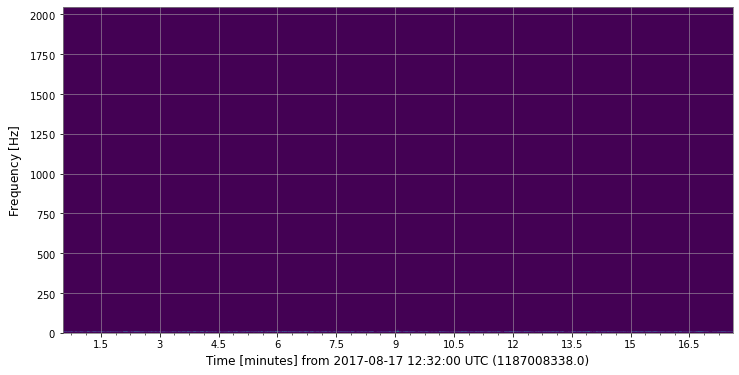

In [18]:
specgram = ldata.spectrogram2(fftlength=4, overlap=2, window='hann') ** (1/2.)
plot = specgram.plot()

Hmmm... something's not right. Can you spot the only "hot" point in this colormap? Maybe the default scale of the color axis is not suitable to fit the excursion of values in this map. **Pro Tip**: check `specgram.min()` and `specgram.max()` values to see if the previous guess is right or not.

We can fix this by passing a few more arguments to our plot to control the display (especially the colouring):

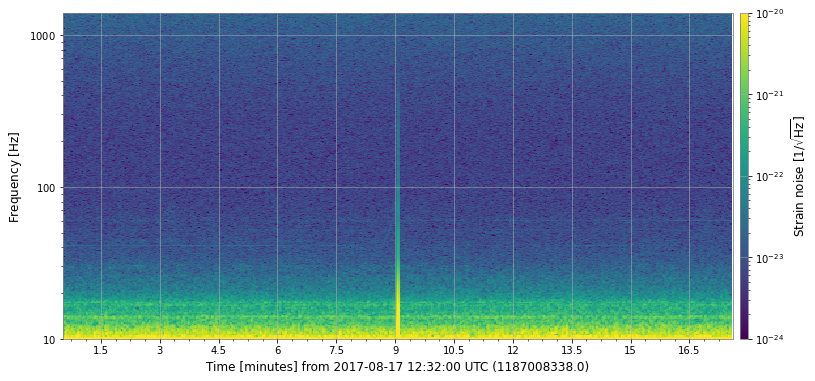

In [19]:
ax = plot.gca()
ax.set_yscale('log')
ax.set_ylim(10, 1400)
ax.colorbar(
    clim=(1e-24, 1e-20),
    norm="log",
    label=r"Strain noise [$1/\sqrt{\mathrm{Hz}}$]",
)
plot  # refresh

Here we can see how the ASD for LIGO-Livingston evolves over a ~17 minute span around GW170817. Four order of magnitudes in the ASD intensity are involved, and this is why the previous attempt resulted in a (almost) fully dark blue image.

We can see that the low-frequency noise (<30 Hz) rumbles along with some variation, but high frequencies (>100 Hz) are relatively stable. Between 30-100 Hz we can see some narrow features appearing and disappearing as non-stationary noise affects the measurement.

## Spectrogram challenge! 

- download the data for all three detectors involved with the GW170814 detection, generate a PSD for each, and make a plot
- make a spectrogram of data for 10 minutes around the GW170817 detection for the LIGO-Livingston detector

## Q-transforms in GWpy

The spectrogram above is a useful way to show the variation of a power spectral density (PSD) estimate over time. It's best used to see general trends in how the sensitivity of the GW detectors is changing over longish periods (minutes or hours).

In this section, we will see how we can use a special filter called a Q-transform to create a time-frequency representation of our data that allows use to pick out features at different frequencies, and how they evolve over very short times, without much prior knowledge of the signal morphology.

See [this article](https://doi.org/10.1088/0264-9381/21/20/024) for more details on the Q-transform and its application to gravitational-wave data.

First, lets reload some data from LIGO Hanford around GW170817:

In [20]:
segment = (int(gps) - 30, int(gps) + 2)
hdata = TimeSeries.fetch_open_data('H1', *segment, verbose=True, cache=True)

Fetched 1 URLs from www.gw-openscience.org for [1187008852 .. 1187008884))
Reading data... [Done]


We can now use the `q_transform()` method of the `hdata` `TimeSeries` to create our time-frequency representation (as a [spectrogram](https://gwpy.github.io/docs/stable/spectrogram/)).

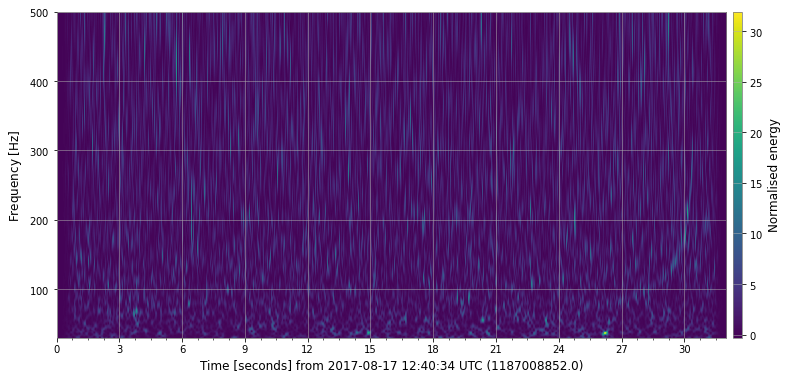

In [21]:
hq = hdata.q_transform(frange=(30, 500))
plot = hq.plot()
plot.colorbar(label="Normalised energy")

From this we can see a different representation of the data. Because the Q-transform returns (by default) normalised energy, the low-frequency rumbling is now much less obvious, and we can see better some noises at higher frequencies.

But, we can clean up the display to better visualise the data:

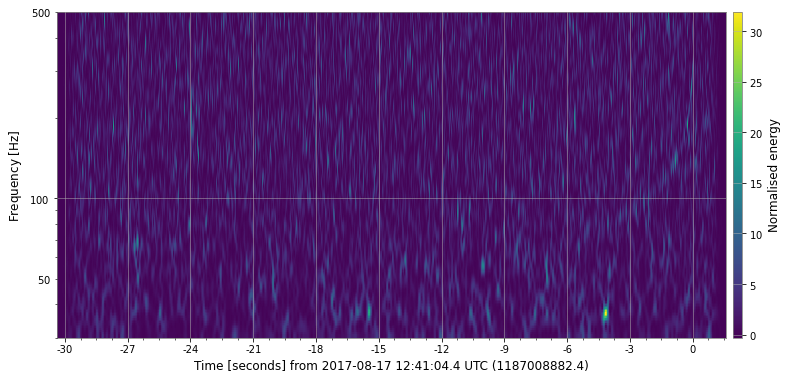

In [22]:
ax = plot.gca()
ax.set_epoch(gps)
ax.set_ylim(30, 500)
ax.set_yscale("log")
plot  # refresh

Now we can see a more prominent feature starting at ~-6 seconds that looks a little familiar.
Here we can use our knowledge of the Q-transform, and our hunch about the origin of the 'feature' to choose a more specific range of 'Q' for the Q-transform, so as to better resolve the feature:

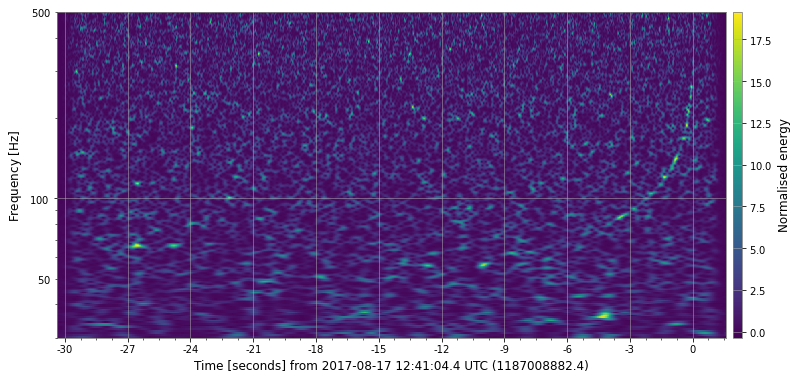

In [23]:
hq = hdata.q_transform(frange=(30, 500), qrange=(100, 110))
plot = hq.plot()
ax = plot.gca()
ax.set_epoch(gps)
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")

Now we see the beautiful, clear track of a BNS merger, visible from about -4 seconds (maye -10 if you squint), all the way through to the merger at T=0.

HINT: We can also use the `outseg` option to zoom in around the merger:

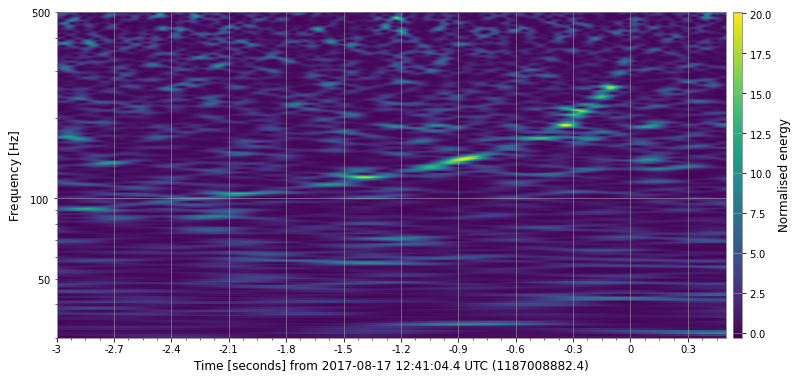

In [24]:
#-- Use OUTSEG for small time range
hq2 = hdata.q_transform(frange=(30, 500), qrange=(80, 110), outseg=(gps-3,gps+0.5)) 
plot = hq2.plot()
ax = plot.gca()
ax.set_epoch(gps)
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")

We can repeat the exercise using LIGO-Livingston data to see something even more remarkable.
First we download and filter the Livingston data:

In [25]:
ldata = TimeSeries.fetch_open_data('L1', *segment, verbose=True)

Fetched 1 URLs from www.gw-openscience.org for [1187008852 .. 1187008884))
Reading data... [Done]


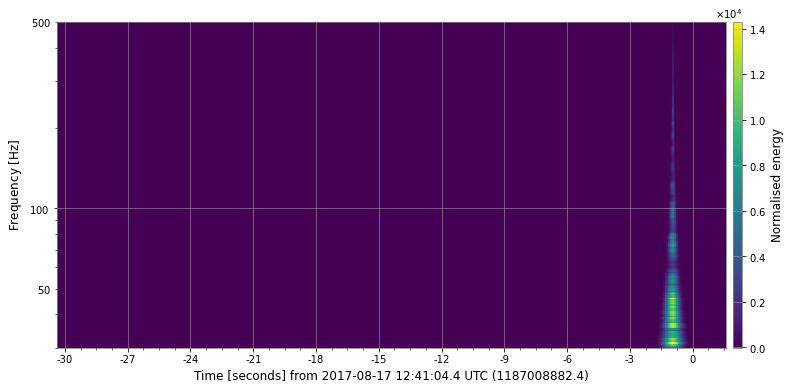

In [26]:
lq = ldata.q_transform(frange=(30, 500), qrange=(100, 110))
plot = lq.plot()
ax = plot.gca()
ax.set_epoch(gps)
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")

Now we can see a large blob of energy that is 1000 times louder than what we see in the LIGO-Hanford data.
As luck would have it, an instrumental glitch almost exactly overlaps the BNS signal in LIGO-Livingston.
But, we can rescale things to see the astrophyscal signal better:

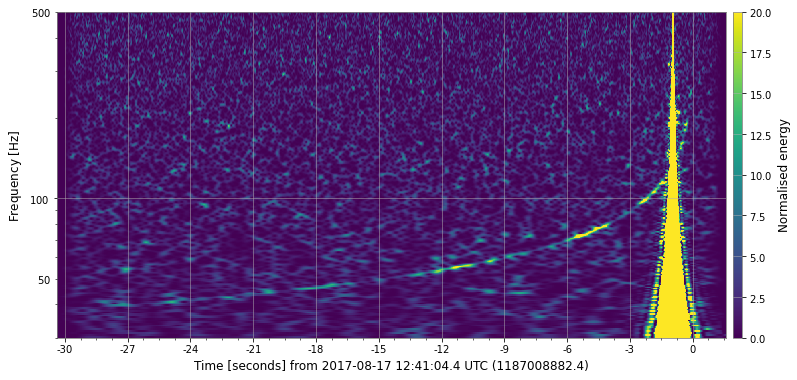

In [27]:
plot.colorbars[0].mappable.set_clim(0,20)
plot.refresh()
plot

Now we can see the BNS signal track all the way back to T=-28 seconds in LIGO-Livingston data!

However, there is still the large glitch that makes it difficult to see the signal near merger. This loud of a glitch is particularly troublesome for any analyses that want to use this data. In order to address these types of loud glitches, a technique called **gating** is commonly used. We will use the `gwpy.TimeSeries.gate()` method to gate the data. 

In order to apply a gate, the data is multiplied by a window function. The `gwpy` method we are using uses an inverse Planck window, but other windows, such as a Turkey window, are also commonly used. After multiplying by the window, the data directly surrounding the glitch will be zeroed. It is also important that the window function inlcudes a transition from 0 to 1 so that there are not any discontinuities introduced. An example of a window fucntion can be seen in the lower panel of Fig. 2 from the GW170817 discovery paper. 

An additional feature of `gwpy.TimeSeries.gate()` is that the times that are gated are identified automatically. This is done by finding data points with an absolute value above some threshold in the whitened data. The default threshold is `50`. 

Let's now apply gates to the Livingston data and remake the plot: 

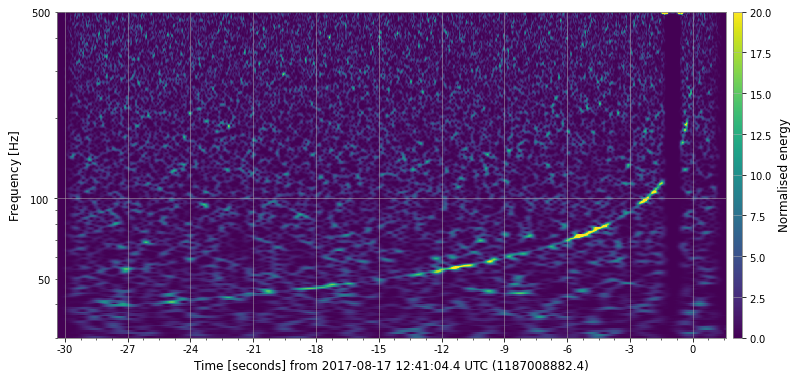

In [28]:
gated_ldata = ldata.gate(tzero=0.25, tpad=0.25)

gated_lq = gated_ldata.q_transform(frange=(30, 500), qrange=(100, 110))
plot = gated_lq.plot()
ax = plot.gca()
ax.set_epoch(gps)
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")
plot.colorbars[0].mappable.set_clim(0,20)

Now the signal is a bit easier to see, but some of our data is now missing. Hence gating can be a great way to deal with loud glitches, but only should be used sparingly. 

This is basically the same procedure (and the same code) that was used to produce Figures 1 and 2 of the BNS discovery article '_Observation of Gravitational Waves from a Binary Neutron Star Inspiral_' [[link](https://doi.org/10.1103/PhysRevLett.119.161101)]

## Q-scan challenge! 

- Download the data for the LIGO-Livingston detector (L1)  around the GW170814 detection, and make a Q-scan of the data.
- The signal is visible for how about how much time?

In [ ]:
from gwosc.datasets import event_gps
from gwpy.timeseries import TimeSeries, TimeSeriesDict
gps = event_gps('GW170814')
print("GW170814 GPS:", gps)

data = TimeSeries.fetch_open_data('L1', int(gps)-512, int(gps)+512, cache=True, verbose=True)
QT = data.q_transform(frange=(20, 500), qrange=(4, 12), outseg=(gps-.1,gps+.05))
QT.plot()

GW170814 GPS: 1186741861.5
Fetched 1 URLs from www.gw-openscience.org for [1186741349 .. 1186742373))
Reading data... [Done]
